In [13]:
import torch
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, random_split
import torch.nn.functional as F
from torchvision import models

import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, confusion_matrix ,roc_curve
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
chunk_size = 25

# List of Parquet file paths
file_paths = [
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet',
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet',
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet'
]

# Initialize an empty list to store dataframes
dfs = []

# Loop through each file path
for file_path in file_paths:
    # Create a Parquet file reader object
    parquet_file = pq.ParquetFile(file_path)
    
    # Determine the total number of rows in the file
    total_rows = parquet_file.metadata.num_rows
    
    # Calculate the number of chunks
    num_chunks = total_rows // chunk_size + (1 if total_rows % chunk_size else 0)
    
    # Loop over the file in chunks
    for chunk_index in range(num_chunks):
        # Read a chunk of rows from the file
        chunk = parquet_file.read_row_group(chunk_index, columns=None)
        df = chunk.to_pandas()
        
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all the DataFrames into a single DataFrame
data = pd.concat(dfs, ignore_index=True)

In [3]:
def to_3d(arr):
    vishak=[]
    for i in range (0,3):
        vis=np.stack(np.stack(arr)[i],axis=-1)
        vishak.append(vis)
    vishak=np.array(vishak)
    return vishak

In [4]:
data["X_jets"]  = data["X_jets"].apply(to_3d)

In [5]:
class task2Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Assuming 'X_jets' column contains paths to images or actual image data
        X = self.dataframe.iloc[idx]['X_jets']
        mean = X.mean(axis=(0, 1, 2), keepdims=True)
        std = X.std(axis=(0, 1, 2), keepdims=True)

        # Normalize each channel separately
        X = (X - mean) / std
        y = self.dataframe.iloc[idx]['y']
        
        if self.transform:
            X = self.transform(X)
        
        # Convert X and y to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float)
        y_tensor = torch.tensor(y, dtype=torch.long)

        return X_tensor, y_tensor


In [6]:
jet_dataset = task2Dataset(dataframe=data)


train_dataset, val_dataset = train_test_split(jet_dataset, test_size=0.2, random_state=42)
val_loader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=False)

In [7]:
class VGG12(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG12, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 3 * 3, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (3, 3))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create the model
model = VGG12(num_classes=2)
print(model)

VGG12(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (18): ReLU(inplace=True)


# Inference

In [8]:
model_weights_path = "/kaggle/input/ml4sci-24-task2-final/model_weights8.pth"

# Load the model weights
model.load_state_dict(torch.load(model_weights_path))

# Set the model to evaluation mode if you're doing inference
model.eval()

VGG12(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (18): ReLU(inplace=True)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [18]:
model.eval()  # Set the model to evaluation mode
y_true = []
y_scores = []

with torch.no_grad():  # Inference without gradient calculation
    for inputs, labels in val_loader:
        inputs = inputs.to(device)  # Adjust this line if needed
        labels = labels.to(device)
        outputs = model(inputs)
        # Apply sigmoid if your model outputs logits
        probs = torch.sigmoid(outputs).squeeze()
        
        # Assuming the positive class is the second column
        positive_class_probs = probs[:, 1] if probs.ndim == 2 else probs
        
        # Store true labels and positive class predictions
        y_true.extend(labels.tolist())
        y_scores.extend(positive_class_probs.tolist())

# Now both y_true and y_scores are 1-dimensional
roc_auc = roc_auc_score(y_true, y_scores)
print(f'ROC AUC Score: {roc_auc}')


ROC AUC Score: 0.7841266465599463


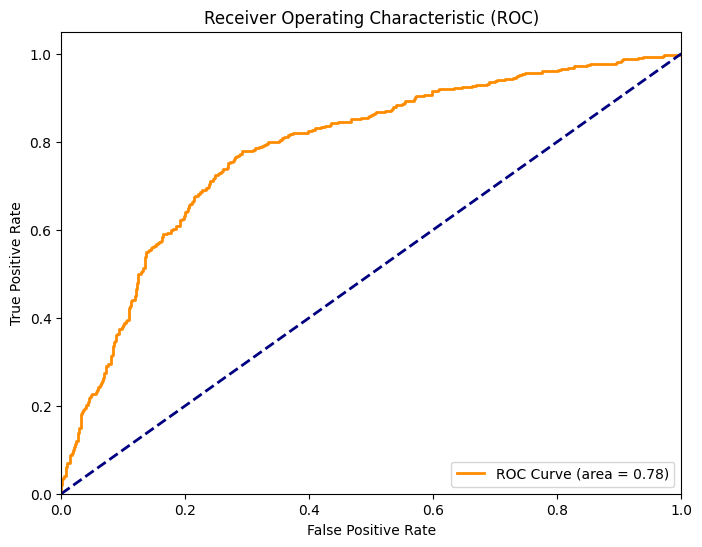

In [19]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()